# Projet CNAM-UASB03 - "Prévision" des catastrophes naturelles en France

## Partie : Choix parmi les modeles conçus



Dépôt du projet :

* https://gitlab.com/logrus_fr/CNAM-UASB03

Auteur : 

* Fabrice DUNAN <fabrice.dunan@laposte.net>

Tuteurs CNAM : 

* N.Niang, M.Crucianu, P.Rigaux

## ATTENTION

Ce notebook est un véritable cahier de brouillon. Il a vocation de donner des résultats "techniques" sans tout expliquer. Se référer au rapport pour plus d'explications.

## Initialisation des outils Python
Cette section initialise les outils, bibliothèques et parametres necessaires pour l'étude.

##### imports

In [1]:
import sys #only needed to determine Python version number
import os
import glob
import re

In [279]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

IMPORTS SERIALISATION

In [3]:
import pickle as pk

##### IMPORTS ESTIMATION QUALITE

In [4]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#http://scikit-learn.org/0.19/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import precision_recall_curve,average_precision_score

In [5]:
import matplotlib
from matplotlib import pyplot as plt#only needed to determine Matplotlib version number
# Enable inline plotting
%matplotlib inline

##### options pandas

In [6]:
#https://stackoverflow.com/questions/11707586/python-pandas-how-to-widen-output-display-to-see-more-columns
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### versions bibliotheques

In [280]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)print('Sklearn version' + sk.__version__ )

Python version 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
Pandas version 0.23.3
Matplotlib version 2.1.1
Sklearn version0.19.1


##### Reglages OS dependants

In [8]:
print (os.name)

posix


In [9]:
windows_path = 'C:\\PFD\\Data\\git\\_PRV\\CNAM-UASB03\\donnees'
linux_path= '/home/user/Bureau/CNAM/git/CNAM-UASB03/donnees'

In [10]:
if(os.name == 'nt'):
    os.chdir(windows_path)
    intermediaires_path = os.path.join(windows_path,'intermediaires\\')
else :
    os.chdir(linux_path)
    intermediaires_path = os.path.join(linux_path,'intermediaires/')

In [11]:
print(intermediaires_path)

/home/user/Bureau/CNAM/git/CNAM-UASB03/donnees/intermediaires/


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/home/user/.local/share/jupyter


## Import et exploration des données

Cette section permet d'importer le fichier de données initial dans les outils informatiques choisis(python et ses bibliothèques)

In [14]:
%%time
#CPU times: user 5.41 s, sys: 500 ms, total: 5.91 s
#Wall time: 7.13 s
#index_col=0,
meteo_cata_DF=pd.read_csv(os.path.join(intermediaires_path,"meteo_stations_catastrophes_alt.csv"),encoding='UTF-8',sep=',',skip_blank_lines=True, header=0,skipinitialspace=True,parse_dates=[1],infer_datetime_format=True,dayfirst=False)

CPU times: user 1.03 s, sys: 112 ms, total: 1.14 s
Wall time: 1.14 s


In [15]:
meteo_cata_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453643 entries, 0 to 453642
Data columns (total 16 columns):
numer_sta        453643 non-null int64
date             453643 non-null datetime64[ns]
t                453643 non-null float64
tn12             453564 non-null float64
tx12             453564 non-null float64
n                453643 non-null float64
raf10            453643 non-null float64
ff               453643 non-null float64
pres             453643 non-null float64
tend             453643 non-null float64
rr3              453643 non-null float64
u                453643 non-null float64
geop             453643 non-null float64
vv               453643 non-null float64
ht_neige         453643 non-null float64
iscatastrophe    453643 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(13), int64(1)
memory usage: 52.3 MB


In [16]:
meteo_cata_DF.date.head()

0   2006-12-06
1   2006-12-06
2   2006-12-06
3   2006-12-06
4   2006-12-06
Name: date, dtype: datetime64[ns]

In [17]:
meteo_cata_DF.head()

,numer_sta,date,t,tn12,tx12,n,raf10,ff,pres,tend,rr3,u,geop,vv,ht_neige,iscatastrophe
0,7005,2006-12-06,289.85,291.85,297.55,63.560525,0.0,3.1,101250.0,-50.0,0.0,90.0,0.0,20866.014525,0.0,False
1,7015,2006-12-06,293.45,291.85,297.55,50.000000,0.0,3.1,101690.0,40.0,0.0,61.0,0.0,20000.000000,0.0,False
2,7020,2006-12-06,289.05,291.85,297.55,63.560525,0.0,6.2,101850.0,-130.0,0.0,88.0,0.0,20866.014525,0.0,False
3,7027,2006-12-06,286.85,291.85,297.55,63.560525,0.0,1.0,101240.0,-100.0,0.0,93.0,0.0,11000.000000,0.0,False
4,7037,2006-12-06,290.45,291.85,297.55,63.560525,0.0,2.1,100340.0,-20.0,0.0,81.0,0.0,35000.000000,0.0,False


#### DISTRIBUTION VARIABLE A PREDIRE

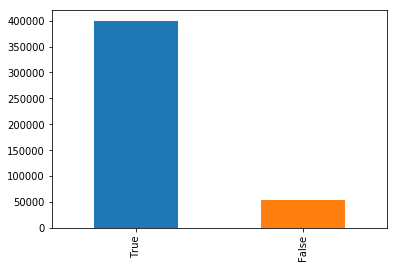

In [18]:
meteo_cata_DF.iscatastrophe.value_counts().plot(kind='bar')

In [19]:
meteo_cata_ko_DF=meteo_cata_DF[meteo_cata_DF.iscatastrophe==False]
meteo_cata_ok_DF=meteo_cata_DF[meteo_cata_DF.iscatastrophe==True]
row_nb_pos,_=meteo_cata_ok_DF.shape
row_nb_neg,_=meteo_cata_ko_DF.shape
print("neg:",row_nb_neg, row_nb_neg/(row_nb_pos+row_nb_neg)*100)
print("pos:",row_nb_pos,row_nb_pos/(row_nb_pos+row_nb_neg)*100)

neg: 53502 11.793855520750899
pos: 400141 88.2061444792491


## REDUCTION INDIVIDUS

Choix:
* classification (kmeans ou CAH)
* PCA individus
* **selection sur la nature de la catastrophe**
* **downsampling**

#### DOWNSAMPLING VARIABLE MAJORITAIRE

In [20]:
meteo_cata_dwn_pos_DF= resample(meteo_cata_ok_DF, 
                                 replace=True,     # sample with replacement
                                 n_samples=row_nb_neg,    # to match majority class
                                 random_state=123) # reproducible results

In [21]:
meteo_cata_eq_DF=pd.concat([meteo_cata_ko_DF,meteo_cata_dwn_pos_DF])

In [22]:
meteo_cata_eq_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107004 entries, 0 to 268418
Data columns (total 16 columns):
numer_sta        107004 non-null int64
date             107004 non-null datetime64[ns]
t                107004 non-null float64
tn12             106996 non-null float64
tx12             106996 non-null float64
n                107004 non-null float64
raf10            107004 non-null float64
ff               107004 non-null float64
pres             107004 non-null float64
tend             107004 non-null float64
rr3              107004 non-null float64
u                107004 non-null float64
geop             107004 non-null float64
vv               107004 non-null float64
ht_neige         107004 non-null float64
iscatastrophe    107004 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(13), int64(1)
memory usage: 13.2 MB


In [23]:
meteo_cata_eq_DF.iscatastrophe.value_counts()

True     53502
False    53502
Name: iscatastrophe, dtype: int64

#### UPSAMPLING VARIABLE MINORITAIRE (non utilise)

### JEU DONNEES FINAL
constitution des predictives et de la variable à prédire

In [24]:
Y=meteo_cata_eq_DF.iscatastrophe
X=meteo_cata_eq_DF.drop(['iscatastrophe','date','numer_sta'],1)

In [25]:
Y.isna().sum()

0

In [26]:
X.isna().sum()

t           0
tn12        8
tx12        8
n           0
raf10       0
ff          0
pres        0
tend        0
rr3         0
u           0
geop        0
vv          0
ht_neige    0
dtype: int64

In [258]:
#on complete les 8 valeurs manquantes ....
X.fillna(inplace=True,method="bfill")

In [28]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

## CHOIX DES ALGORITHMES PREDICTIFS

##### FONCTION AUXILIAIRES

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

In [33]:
#precision_recall_curve(modele_ada,probas_pred=1)

### **RF ET BOOSTING RF**

In [34]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [35]:
# forets aléatoires 
modele_rf=RandomForestClassifier(n_estimators=100, random_state=42)
#methodes ensemble
modele_ada=AdaBoostClassifier(n_estimators=100, random_state=42)
modele_gbm=GradientBoostingClassifier(n_estimators=100, random_state=42)

##### APPRENTISSAGE

In [36]:
%%time
#en upsampling
#CPU times: user 37min 9s, sys: 6.21 s, total: 37min 15s
#Wall time: 37min 16s
modele_rf.fit(X_train, Y_train)

CPU times: user 13.3 s, sys: 71.6 ms, total: 13.4 s
Wall time: 13.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
%%time
modele_ada.fit(X_train, Y_train)

CPU times: user 6.67 s, sys: 12.1 ms, total: 6.69 s
Wall time: 6.69 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=42)

In [38]:
%%time
modele_gbm.fit(X_train, Y_train)

CPU times: user 9.22 s, sys: 12.3 ms, total: 9.23 s
Wall time: 9.24 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

##### PREDICTIONS

In [39]:
modele_rf_pred=modele_rf.predict(X_test)

In [40]:
modele_ada_pred=modele_ada.predict(X_test)

In [41]:
modele_gbm_pred=modele_gbm.predict(X_test)

##### **ESTIMATION QUALITE MODELE RF**

In [42]:
modele_pred = modele_rf_pred
modele = modele_rf

##### Matrice confusion

In [43]:
confusion_matrix(Y_test,modele_pred)

array([[10013,   791],
       [  373, 10224]])

##### ROC

In [44]:
roc_auc_score(Y_test, modele_pred)

0.9457938671458329

##### ROC CURVE

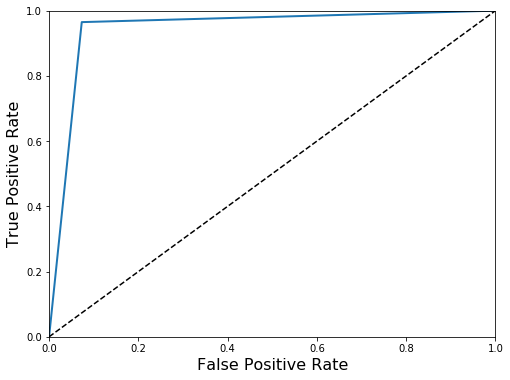

In [45]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [46]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.9281888334089877, 0.9648013588751534, 0.946141032759578, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [47]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.52806122 0.59209027 0.99186362 0.98184598 0.97869913 0.98901099
 0.98415123 0.96913232 0.95390335 0.90700547]
Mean: 0.8875763566114621
Standard deviation: 0.16603401419701555
CPU times: user 378 ms, sys: 68.2 ms, total: 447 ms
Wall time: 1min


In [48]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.96710895 0.97084657 0.95700935 0.96037383 0.96186916 0.9588785
 0.96336449 0.96242991 0.95925234 0.96074766]
Mean: 0.9621880755977135
Standard deviation: 0.0039049458902022404
CPU times: user 371 ms, sys: 76.1 ms, total: 447 ms
Wall time: 1min


In [49]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.68312323 0.73557522 0.97412481 0.97099121 0.97021116 0.97371168
 0.97364693 0.96576948 0.95657036 0.93310339]
Mean: 0.913682747139938
Standard deviation: 0.10350925606418922
CPU times: user 346 ms, sys: 104 ms, total: 451 ms
Wall time: 1min


In [50]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.69320837 0.80238174 0.99718674 0.99546884 0.99507157 0.99596574
 0.99644652 0.99165931 0.99138267 0.98061771]
Mean: 0.9439389210946635
Standard deviation: 0.10116658312273903
CPU times: user 382 ms, sys: 72.6 ms, total: 455 ms
Wall time: 1min


##### **ESTIMATION QUALITE MODELE ADA**

In [51]:
modele_pred = modele_ada_pred
modele=modele_ada

##### Matrice confusion

In [52]:
confusion_matrix(Y_test,modele_pred)

array([[9231, 1573],
       [ 639, 9958]])

##### ROC

In [53]:
roc_auc_score(Y_test, modele_pred)

0.8970528453544777

##### ROC CURVE

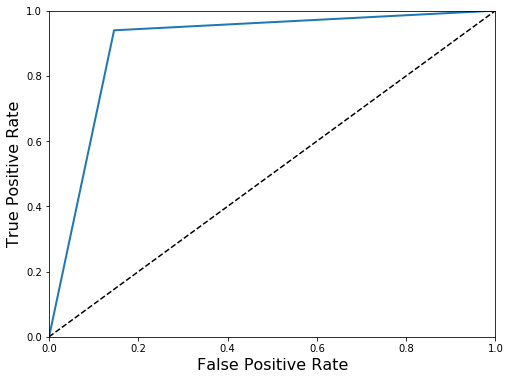

In [54]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [55]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.8635851183765502, 0.9396999150703029, 0.9000361532899495, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [56]:
%%time
modele_score_acc=cross_val_score(modele,X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.52097221 0.59593706 0.97970043 0.98112837 0.95954537 0.96506889
 0.95477194 0.94409584 0.94439154 0.92791783]
Mean: 0.877352948377862
Standard deviation: 0.16105758438579176
CPU times: user 337 ms, sys: 116 ms, total: 453 ms
Wall time: 32.8 s


In [57]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.94935526 0.94842086 0.92915888 0.9328972  0.93102804 0.92953271
 0.93121495 0.92803738 0.92691589 0.92878505]
Mean: 0.9335346210071662
Standard deviation: 0.0078467246686113
CPU times: user 359 ms, sys: 83.2 ms, total: 442 ms
Wall time: 32.2 s


In [58]:
%%time
modele_score_acc=cross_val_score(modele, X, Y,cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.67275858 0.73195356 0.95376055 0.9564051  0.94507163 0.94696753
 0.94284633 0.93599774 0.93557212 0.92835124]
Mean: 0.8949684361708116
Standard deviation: 0.09753719851297267
CPU times: user 355 ms, sys: 72.3 ms, total: 428 ms
Wall time: 32.6 s


In [59]:
%%time
modele_score_roc=cross_val_score(modele,X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.65381581 0.76402286 0.99316508 0.9931764  0.98676906 0.9895862
 0.9890175  0.98266781 0.98413086 0.98085759]
Mean: 0.931720917838898
Standard deviation: 0.11415972989866363
CPU times: user 338 ms, sys: 87.9 ms, total: 426 ms
Wall time: 32 s


##### **ESTIMATION QUALITE MODELE GBM**

In [60]:
modele_pred = modele_gbm_pred
modele=modele_gbm

##### Matrice confusion

In [61]:
confusion_matrix(Y_test,modele_pred)

array([[ 9358,  1446],
       [  581, 10016]])

##### ROC

In [62]:
roc_auc_score(Y_test, modele_pred)

0.9056669217224479

##### ROC CURVE

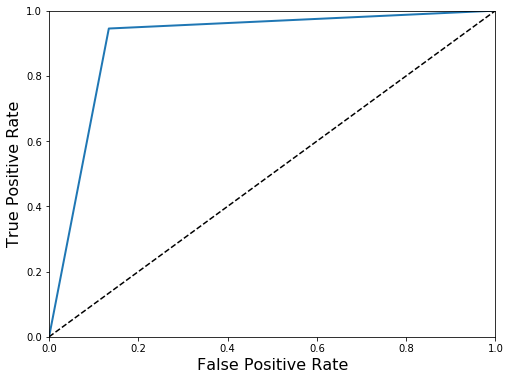

In [63]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [64]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.8738440062816263, 0.9451731622157215, 0.9081100684527857, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [65]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.5191659  0.57664151 0.98838583 0.98554688 0.97589425 0.97547684
 0.97359736 0.95694604 0.95623925 0.91869621]
Mean: 0.8826590059611231
Standard deviation: 0.16892218857648453
CPU times: user 411 ms, sys: 92.4 ms, total: 503 ms
Wall time: 59.1 s


In [66]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.94916838 0.9568305  0.93850467 0.94317757 0.93831776 0.93682243
 0.93738318 0.93476636 0.9353271  0.93775701]
Mean: 0.9408054953480616
Standard deviation: 0.0066873184210212416
CPU times: user 393 ms, sys: 72.6 ms, total: 465 ms
Wall time: 59.4 s


In [67]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.67120391 0.71960647 0.96279962 0.96389685 0.95673718 0.95575896
 0.95514713 0.94572617 0.94566758 0.92812876]
Mean: 0.9004672626479777
Standard deviation: 0.10356201355194058
CPU times: user 387 ms, sys: 81.2 ms, total: 468 ms
Wall time: 59.6 s


In [68]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.67375455 0.77056851 0.99526332 0.99434319 0.9916656  0.99217879
 0.99247068 0.98691868 0.98790231 0.98151926]
Mean: 0.9366584899953871
Standard deviation: 0.10947794539933293
CPU times: user 377 ms, sys: 80.6 ms, total: 458 ms
Wall time: 59.1 s


#### *Importance des variables dans le modele*

In [69]:
modele_rf.feature_importances_

array([0.07201836, 0.10600016, 0.11498856, 0.06354506, 0.35909978,
       0.03830383, 0.09052431, 0.03374793, 0.02425722, 0.03686312,
       0.00648497, 0.05340613, 0.00076057])

In [70]:
pd.DataFrame(modele_rf.feature_importances_,index=X_train.columns,columns=["Importance"]).head()

,Importance
t,0.072018
tn12,0.106000
tx12,0.114989
n,0.063545
raf10,0.359100


In [71]:
pd.DataFrame(modele_gbm.feature_importances_,index=X_train.columns,columns=["Importance"]).head()

,Importance
t,0.048091
tn12,0.138567
tx12,0.153798
n,0.145986
raf10,0.223895


In [72]:
pd.DataFrame(modele_ada.feature_importances_,index=X_train.columns,columns=["Importance"]).head()

,Importance
t,0.05
tn12,0.22
tx12,0.26
n,0.08
raf10,0.06


### **NAIF BAYESIEN**

In [73]:
from sklearn.naive_bayes import GaussianNB
modele_gnb = GaussianNB()

In [74]:
gmodel = modele_gnb.fit(X_train,Y_train)
modeleNB_pred = gmodel.predict(X_test)

In [75]:
X_test.shape[0]

21401

In [76]:
Y_test_v=Y_test.values
Y_test_v=Y_test_v.ravel()
Y_test_v

array([False, False,  True, ...,  True, False,  True])

In [77]:
modeleNB_pred

array([False, False,  True, ...,  True, False, False])

In [78]:
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (Y_test_v != modeleNB_pred).sum(),
          100*(1-(Y_test_v != modeleNB_pred).sum()/X_test.shape[0])))

Number of mislabeled points out of a total 21401 points : 5514, performance 74.23%


##### **ESTIMATION QUALITE MODELE NAIF BAYESIEN**

In [79]:
modele_pred = modeleNB_pred
modele = modele_gnb

##### Matrice confusion

In [80]:
confusion_matrix(Y_test,modele_pred)

array([[9706, 1098],
       [4416, 6181]])

##### ROC

In [81]:
roc_auc_score(Y_test, modele_pred)

0.7408246300104424

##### ROC CURVE

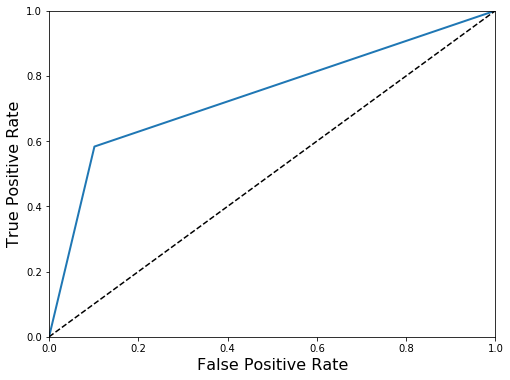

In [82]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [83]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.8491551037230389, 0.5832782863074455, 0.6915417319310808, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [84]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.61744138 0.69470828 0.9785394  0.97581425 0.95939566 0.97977162
 0.97151088 0.96404425 0.84770742 0.67586934]
Mean: 0.8664802477954898
Standard deviation: 0.13954943916107906
CPU times: user 313 ms, sys: 60.6 ms, total: 374 ms
Wall time: 510 ms


In [85]:
%%time
modele_score_acc=cross_val_score(modele, X, Y,cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.56101663 0.5740983  0.57102804 0.56560748 0.56971963 0.56130841
 0.56728972 0.58635514 0.58056075 0.59943925]
Mean: 0.5736423343003405
Standard deviation: 0.011462284269150745
CPU times: user 295 ms, sys: 68.4 ms, total: 363 ms
Wall time: 516 ms


In [86]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.58787819 0.62867083 0.72119924 0.71612827 0.71490559 0.71372549
 0.71630871 0.72919572 0.68915021 0.63536404]
Mean: 0.6852526304154557
Standard deviation: 0.04692364553042146
CPU times: user 324 ms, sys: 56.6 ms, total: 380 ms
Wall time: 511 ms


In [87]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.59974573 0.72785046 0.92345298 0.92822917 0.93643357 0.94320543
 0.92028942 0.88698816 0.84256538 0.74523707]
Mean: 0.8453997375952185
Standard deviation: 0.11061126443525086
CPU times: user 308 ms, sys: 60.3 ms, total: 369 ms
Wall time: 512 ms


### **REGRESSION LOGISTIQUE**

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
# Set regularization parameter
for _, C in enumerate((100, 1, 0.01)):
    # turn down tolerance for short training time
    modele_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    modele_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    modele_l1_LR.fit(X_train, Y_train)
    modele_l2_LR.fit(X_train, Y_train)

    coef_l1_LR = modele_l1_LR.coef_.ravel()
    coef_l2_LR = modele_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % modele_l1_LR.score(X_test, Y_test))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % modele_l2_LR.score(X_test, Y_test))

C=100.00
Sparsity with L1 penalty: 0.00%
score with L1 penalty: 0.8285
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.7428
C=1.00
Sparsity with L1 penalty: 0.00%
score with L1 penalty: 0.8285
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.7263
C=0.01
Sparsity with L1 penalty: 7.69%
score with L1 penalty: 0.8273
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.7422


In [90]:
modele_l1_LR_pred = modele_l1_LR.predict(X_test)
modele_l2_LR_pred= modele_l2_LR.predict(X_test)

##### **ESTIMATION QUALITE MODELE REGRESSION LOGISTIQUE**

In [91]:
modele_pred = modele_l1_LR_pred
#modele_pred = modele_l2_LR_pred
modele = modele_l1_LR
#modele = modele_l2_LR

##### Matrice confusion

In [92]:
confusion_matrix(Y_test,modele_pred)

array([[8464, 2340],
       [1355, 9242]])

##### ROC

In [93]:
roc_auc_score(Y_test, modele_pred)

0.8277735866301252

##### ROC CURVE

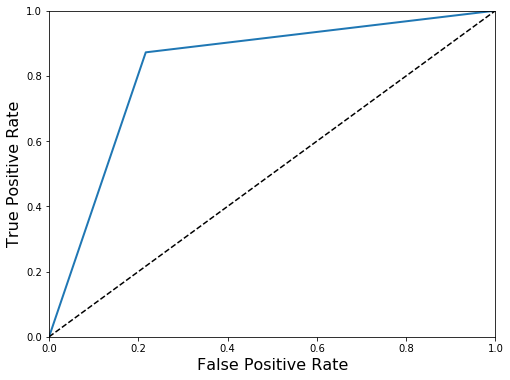

In [94]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [95]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.7979623553790365, 0.8721336227234123, 0.8334009648766854, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [96]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.53538774 0.63614554 0.88172249 0.91777031 0.88083491 0.9122145
 0.88966049 0.82904609 0.87528824 0.79014879]
Mean: 0.8148219110345745
Standard deviation: 0.12206304653896215
CPU times: user 541 ms, sys: 111 ms, total: 652 ms
Wall time: 2min 49s


In [97]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.88637638 0.89198281 0.8611215  0.86785047 0.86766355 0.85850467
 0.86205607 0.86747664 0.85140187 0.8635514 ]
Mean: 0.8677985353423328
Standard deviation: 0.01175143896730753
CPU times: user 546 ms, sys: 106 ms, total: 651 ms
Wall time: 2min 49s


In [98]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.66755806 0.7426482  0.87130024 0.89211259 0.87419962 0.88454502
 0.87564078 0.84782609 0.86317984 0.82522104]
Mean: 0.834423147964419
Standard deviation: 0.06916582873134833
CPU times: user 556 ms, sys: 121 ms, total: 678 ms
Wall time: 2min 48s


In [99]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.64783022 0.74865915 0.93904687 0.95078368 0.93304425 0.94799986
 0.9366446  0.91212057 0.92329989 0.8897589 ]
Mean: 0.8829187987324184
Standard deviation: 0.09654689175372212
CPU times: user 550 ms, sys: 136 ms, total: 687 ms
Wall time: 2min 48s


###  **KNN**

In [100]:
from sklearn.neighbors import KNeighborsClassifier
modele_knn=KNeighborsClassifier()
modele_knn.fit(X_train, Y_train)
modeleKnn_pred=modele_knn.predict(X_test)

##### **ESTIMATION QUALITE MODELE KNN**

In [101]:
modele=modele_knn
modele_pred = modeleKnn_pred

##### Matrice confusion

In [102]:
confusion_matrix(Y_test,modele_pred)

array([[7212, 3592],
       [2572, 8025]])

##### ROC

In [103]:
roc_auc_score(Y_test, modele_pred)

0.7124101716212949

##### ROC CURVE

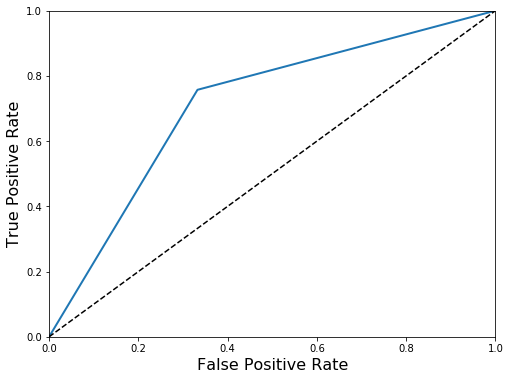

In [104]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [105]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.6907979684944477, 0.7572897989997169, 0.7225173314126226, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [106]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.56614705 0.61450097 0.74907613 0.77323349 0.67779993 0.71510379
 0.71170698 0.68592241 0.72382508 0.6586577 ]
Mean: 0.6875973527111319
Standard deviation: 0.05898564912084765
CPU times: user 362 ms, sys: 80 ms, total: 442 ms
Wall time: 29.6 s


In [107]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.76695945 0.76976266 0.75775701 0.75271028 0.76242991 0.74691589
 0.75906542 0.75682243 0.74560748 0.76859813]
Mean: 0.7586628650073268
Standard deviation: 0.00808193406783947
CPU times: user 358 ms, sys: 67.9 ms, total: 426 ms
Wall time: 29.8 s


In [108]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=10, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.65142857 0.68342459 0.75339156 0.76283387 0.71762843 0.73066374
 0.73462373 0.71963032 0.73455483 0.7093936 ]
Mean: 0.7197573248816875
Standard deviation: 0.03105900547986481
CPU times: user 350 ms, sys: 100 ms, total: 450 ms
Wall time: 30.7 s


In [109]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=10, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.61863541 0.69153529 0.82828151 0.84115261 0.76584816 0.79912543
 0.80227281 0.77246724 0.80830686 0.75427587]
Mean: 0.768190117436766
Standard deviation: 0.06412677633183099
CPU times: user 353 ms, sys: 76.8 ms, total: 430 ms
Wall time: 31.2 s


### **SVM**

In [140]:
# algorithme de classification
from sklearn.svm import SVC

In [141]:
modele_SVM = SVC()

In [142]:
%%time
#CPU times: user 20h 57min 44s, sys: 12.1 s, total: 20h 57min 56s
#Wall time: 21h 35min 25s
modele_SVM.fit(X_train, Y_train)

CPU times: user 16min 11s, sys: 77.2 ms, total: 16min 11s
Wall time: 16min 11s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [146]:
with open("SVM_model.pk", 'wb') as pickle_file:
    pk.dump(all, pickle_file)

In [147]:
modele_SVM_test=modele_SVM.predict(X_test)

##### **ESTIMATION QUALITE MODELE SVM**

In [148]:
modele_pred = modele_SVM_test
modele = modele_SVM

##### Matrice confusion

In [149]:
confusion_matrix(Y_test,modele_pred)

array([[10804,     0],
       [ 9528,  1069]])

##### ROC

In [150]:
roc_auc_score(Y_test, modele_pred)

0.5504388034349345

##### ROC CURVE

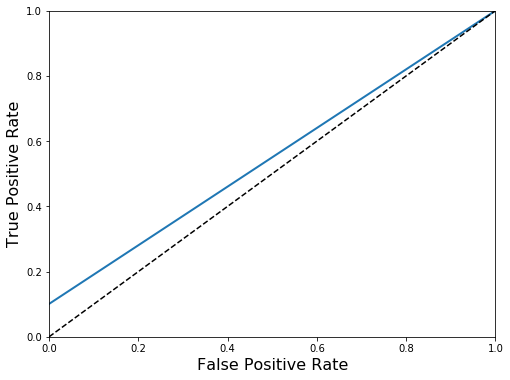

In [151]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [152]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(1.0, 0.10087760686986882, 0.1832676152923024, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 

In [153]:
%%time
modele_score_acc=cross_val_score(modele, X_train, Y_train, cv=3, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.99607458 0.99804878 0.99898785]
Mean: 0.9977037392210842
Standard deviation: 0.0012141053118430185
CPU times: user 683 ms, sys: 228 ms, total: 911 ms
Wall time: 11min 10s


In [154]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=3, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.08680049 0.0853426  0.0865762 ]
Mean: 0.08623976673769206
Standard deviation: 0.000640964008802741
CPU times: user 787 ms, sys: 300 ms, total: 1.09 s
Wall time: 16min 37s


In [155]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=3, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.15969464 0.1572639  0.1593313 ]
Mean: 0.158763280697471
Standard deviation: 0.001070549984412297
CPU times: user 731 ms, sys: 347 ms, total: 1.08 s
Wall time: 17min 20s


In [156]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=3, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.58775037 0.59047879 0.58920838]
Mean: 0.5891458469498364
Standard deviation: 0.0011147530639906667
CPU times: user 767 ms, sys: 276 ms, total: 1.04 s
Wall time: 16min 53s


##### Autres Tests à reporter

In [157]:
# % de bien classes
# attention trompeur
accuracy_score(Y_test,modele_SVM_test)

0.5547871594785291

In [158]:
precision_score(Y_test,modele_SVM_test)

1.0

### **LE MEILLEUR: Random forest**

In [232]:
from sklearn.model_selection import GridSearchCV

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [285]:
parameters = { 
            'n_estimators':[1,500], 
            'criterion' :['gini', 'entropy']
              }

In [234]:
#nb de jeux en CV
nb_cv=5

In [286]:
modele_RF_GSCV = GridSearchCV(modele_rf, parameters,cv=nb_cv,n_jobs=-1)

In [287]:
%%time
modele_RF_GSCV.fit(X_train,Y_train)

CPU times: user 1min 28s, sys: 343 ms, total: 1min 28s
Wall time: 6min 36s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 500], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [288]:
modele_RF_GSCV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

##### Estimation de l'erreur de prévision sur l'échantillon test

In [289]:
modele_RF_GSCV.score(X_test,Y_test)

0.9465912807812719

In [290]:
modele_RF_GSCV_pred=modele_RF_GSCV.predict(X_test)

##### **ESTIMATION QUALITE MODELE RF GRIDSEARCH**

In [291]:
modele_pred = modele_RF_GSCV_pred
modele=modele_RF_GSCV

##### Matrice confusion

In [292]:
confusion_matrix(Y_test,modele_pred)

array([[10040,   764],
       [  379, 10218]])

##### ROC

In [293]:
roc_auc_score(Y_test, modele_pred)

0.9467603053639938

##### ROC CURVE

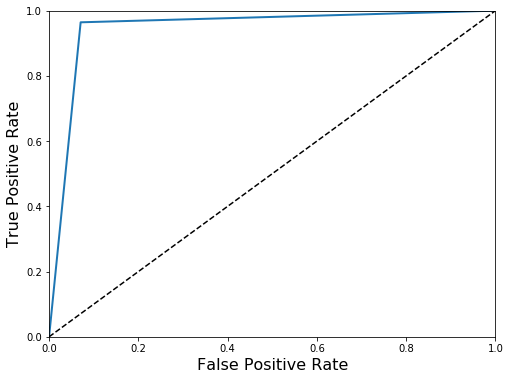

In [294]:
fpr, tpr, thresholds = roc_curve(Y_test, modele_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### PRECISION, RAPPEL, F1-SCORE, SUPPORT

In [295]:
precision_recall_fscore_support(Y_test, modele_pred,average='binary')

(0.9304316153706065, 0.9642351608945928, 0.9470318365077159, None)

##### SCORE EN K-FOLD CROSS VALIDATION (validation croisee en K passes) 
INUTILE DEJA FAIT LORS DE LA GENERATION DU MODELE ! => resultat sous optimal

In [296]:
%%time
#CPU times: user 1.6 s, sys: 543 ms, total: 2.14 s
#Wall time: 30min 30s
modele_score_acc=cross_val_score(modele, X, Y, cv=nb_cv, scoring="precision",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.5286025  0.98738079 0.97614749 0.97413793 0.90340759]
Mean: 0.87393525959312
Standard deviation: 0.1752033889740129
CPU times: user 1.6 s, sys: 543 ms, total: 2.14 s
Wall time: 30min 30s


In [271]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=nb_cv, scoring="recall",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.9766377  0.95785441 0.96       0.96102804 0.9588785 ]
Mean: 0.96287972911956
Standard deviation: 0.006960847101161565
CPU times: user 1.17 s, sys: 390 ms, total: 1.56 s
Wall time: 25min 32s


In [272]:
%%time
modele_score_acc=cross_val_score(modele, X, Y, cv=nb_cv, scoring="f1",n_jobs=-1)
display_scores(modele_score_acc)

Scores: [0.68594119 0.97239351 0.96800641 0.96753858 0.93031691]
Mean: 0.9048393189297055
Standard deviation: 0.1104991805421745
CPU times: user 1.21 s, sys: 372 ms, total: 1.59 s
Wall time: 25min 28s


In [273]:
%%time
modele_score_roc=cross_val_score(modele, X, Y, cv=nb_cv, scoring="roc_auc",n_jobs=-1)
display_scores(modele_score_roc)

Scores: [0.68827536 0.99628681 0.99445123 0.99379531 0.97491813]
Mean: 0.9295453667307703
Standard deviation: 0.12088436685366487
CPU times: user 1.21 s, sys: 386 ms, total: 1.59 s
Wall time: 25min 29s
